## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV


## Fairness metrics function

In [2]:
def calculate_ppv_by_group(y_true, y_pred, groups):
    """
    Calculate the Positive Predictive Value (PPV) for each class and group.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - groups: array-like, group membership for the protected attribute

    Returns:
    - ppvs: Dictionary holding the PPV for each class and group
    """
    classes = np.unique(y_true)  # Unique classes in your target
    unique_groups = np.unique(groups)  # Unique groups in your protected attribute

    # Dictionary to hold PPV for each class and group
    ppvs = {g: {c: None for c in classes} for g in unique_groups}

    for c in classes:
        for g in unique_groups:
            # Indices for the current group
            group_indices = np.where(groups == g)
            # Binarize y_true and y_pred for the current class
            y_true_binarized = (np.array(y_true)[group_indices] == c).astype(int)
            y_pred_binarized = (np.array(y_pred)[group_indices] == c).astype(int)

            # Calculate precision for the current class and group
            precision = precision_score(y_true_binarized, y_pred_binarized, pos_label=1, zero_division=0)
            ppvs[g][c] = round(precision, 3)

    return ppvs


def statistical_parity(data, target, protected_attribute):
    """
    Calculate the Statistical Parity for each class across different groups defined by a protected attribute.

    Parameters:
    - data: DataFrame containing the target labels and the protected attribute.
    - target: string, the name of the column containing the target class labels.
    - protected_attribute: string, the name of the column containing the protected attribute.

    Returns:
    - stat_parity: DataFrame showing the proportion of each class for each group in the protected attribute.
    """
    # Calculate the overall proportions of each class in the target
    overall_proportions = data[target].value_counts(normalize=True)

    # Group data by protected attribute and calculate proportions within each group
    group_proportions = data.groupby(protected_attribute)[target].value_counts(normalize=True).unstack(fill_value=0)

    # Calculate the differences from the overall proportions to assess disparity
    disparity = group_proportions - overall_proportions

    return disparity


def calculate_equalized_odds_differences(y_true, y_pred, groups):
    """
    Calculate and compare the True Positive Rate (TPR) and False Positive Rate (FPR) for each class across different groups defined by a protected attribute. This function identifies the differences to assess Equalized Odds.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - groups: array-like, group membership for the protected attribute

    Returns:
    - comparison_results: DataFrame with differences in TPR and FPR for each class between groups
    """
    # Unique classes and groups
    classes = np.unique(y_true)
    unique_groups = np.unique(groups)

    # DataFrame to store TPR and FPR for each class and group
    metrics = pd.DataFrame()

    for group in unique_groups:
        for class_val in classes:
            # Create mask for the current group and class
            group_mask = (groups == group)
            class_mask_true = (y_true == class_val)
            class_mask_pred = (y_pred == class_val)

            # Confusion matrix for current class and group
            cm = confusion_matrix(class_mask_true[group_mask], class_mask_pred[group_mask])

            # Calculate TPR and FPR
            if cm.shape == (2, 2):  # Typical binary confusion matrix shape
                TN, FP, FN, TP = cm.ravel()
                TPR = TP / (TP + FN) if TP + FN > 0 else 0
                FPR = FP / (FP + TN) if FP + TN > 0 else 0
            else:
                TPR = 0
                FPR = 0

            # Append results
            metrics = pd.concat([metrics, pd.DataFrame({
                'Group': [group],
                'Class': [class_val],
                'TPR': [TPR],
                'FPR': [FPR]
            })], ignore_index=True)

    # Calculate differences in TPR and FPR between groups for each class
    comparison_results = pd.DataFrame()
    for class_val in classes:
        class_data = metrics[metrics['Class'] == class_val]
        if len(unique_groups) > 1:
            for i in range(len(unique_groups)):
                for j in range(i + 1, len(unique_groups)):
                    group1 = unique_groups[i]
                    group2 = unique_groups[j]
                    tpr_diff = abs(class_data[class_data['Group'] == group1]['TPR'].values[0] - class_data[class_data['Group'] == group2]['TPR'].values[0])
                    fpr_diff = abs(class_data[class_data['Group'] == group1]['FPR'].values[0] - class_data[class_data['Group'] == group2]['FPR'].values[0])
                    comparison_results = pd.concat([comparison_results, pd.DataFrame({
                        'Class': [class_val],
                        'Group1': [group1],
                        'Group2': [group2],
                        'TPR Difference': [tpr_diff],
                        'FPR Difference': [fpr_diff]
                    })], ignore_index=True)

    return comparison_results


def calculate_equal_opportunity_differences(y_true, y_pred, groups):
    """
    Calculate and compare the True Positive Rate (TPR) for each class across different groups defined by a protected attribute. This function identifies the differences to assess Equal Opportunity.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - groups: array-like, group membership for the protected attribute

    Returns:
    - comparison_results: DataFrame with differences in TPR for each class between groups
    """
    # Unique classes and groups
    classes = np.unique(y_true)
    unique_groups = np.unique(groups)

    # DataFrame to store TPR for each class and group
    metrics = pd.DataFrame()

    for group in unique_groups:
        for class_val in classes:
            # Create mask for the current group and class
            group_mask = (groups == group)
            class_mask_true = (y_true == class_val)
            class_mask_pred = (y_pred == class_val)

            # Confusion matrix for current class and group
            cm = confusion_matrix(class_mask_true[group_mask], class_mask_pred[group_mask])

            # Calculate TPR (True Positive Rate)
            if cm.shape == (2, 2):  # Typical binary confusion matrix shape
                TN, FP, FN, TP = cm.ravel()
                TPR = TP / (TP + FN) if TP + FN > 0 else 0
            else:
                TPR = 0

            # Append results
            metrics = pd.concat([metrics, pd.DataFrame({
                'Group': [group],
                'Class': [class_val],
                'TPR': [TPR]
            })], ignore_index=True)

    # Calculate differences in TPR between groups for each class
    comparison_results = pd.DataFrame()
    for class_val in classes:
        class_data = metrics[metrics['Class'] == class_val]
        if len(unique_groups) > 1:
            for i in range(len(unique_groups)):
                for j in range(i + 1, len(unique_groups)):
                    group1 = unique_groups[i]
                    group2 = unique_groups[j]
                    tpr_diff = abs(class_data[class_data['Group'] == group1]['TPR'].values[0] - class_data[class_data['Group'] == group2]['TPR'].values[0])
                    comparison_results = pd.concat([comparison_results, pd.DataFrame({
                        'Class': [class_val],
                        'Group1': [group1],
                        'Group2': [group2],
                        'TPR Difference': [tpr_diff]
                    })], ignore_index=True)

    return comparison_results



In [3]:
def fairness_result_function(y_test, y_predict_rf ):
    df_test = y_test.to_frame().copy()    
    df_test['predict'] = y_predict_rf
    cat = pd.concat([X, df_test], axis=1).dropna()
    # cat

    y_true = cat["PerformanceRating"]  # True performance ratings
    y_pred = cat["predict"]  # Predicted performance ratings
    groups_gender = cat["Gender"]  # Protected attribute, gender
    groups_age = cat['Age']  # Protected attribute, age

    # PPV by Gender and Age
    ppvs_gender = calculate_ppv_by_group(y_true, y_pred, groups_gender)
    ppvs_age = calculate_ppv_by_group(y_true, y_pred, groups_age)

    # Statistical Parity Differences
    gender_parity_differences = statistical_parity(cat, "predict", "Gender")
    age_parity_differences = statistical_parity(cat, "predict", "Age")

    # Equalized Odds Differences
    gender_equalized_odd = calculate_equalized_odds_differences(y_true, y_pred, groups_gender)
    age_equalized_odd = calculate_equalized_odds_differences(y_true, y_pred, groups_age)

    # Equal Opportunity Differences
    gender_equal_opportunity = calculate_equal_opportunity_differences(y_true, y_pred, groups_gender)
    age_equal_opportunity = calculate_equal_opportunity_differences(y_true, y_pred, groups_age)

    # # Create a DataFrame to store results
    # results_df = pd.DataFrame({
    #     "Metric": ["PPVs by Gender", "PPVs by Age", "Gender Parity Differences",
    #                "Age Parity Differences", "Gender Equalized Odds Differences",
    #                "Age Equalized Odds Differences", "Gender Equal Opportunity Differences",
    #                "Age Equal Opportunity Differences"],
    #     "Value": [ppvs_gender, ppvs_age, gender_parity_differences, age_parity_differences,
    #               gender_equalized_odd, age_equalized_odd, gender_equal_opportunity, age_equal_opportunity]
    # })

    # return results_df

    print("Fairness Metrics Results:")
    print(f"PPVs by Gender:\n{ppvs_gender}")
    print(f"PPVs by Age:\n{ppvs_age}")
    print(f"Gender Parity Differences:\n{gender_parity_differences}")
    print(f"Age Parity Differences:\n{age_parity_differences}")
    print(f"Gender Equalized Odds Differences:\n{gender_equalized_odd}")
    print(f"Age Equalized Odds Differences:\n{age_equalized_odd}")
    print(f"Gender Equal Opportunity Differences:\n{gender_equal_opportunity}")
    print(f"Age Equal Opportunity Differences:\n{age_equal_opportunity}")

## Loading Dataset

In [4]:
df = pd.read_csv('resampled_dataset.csv')

In [5]:
df.columns

Index(['EducationBackground', 'MaritalStatus', 'EmpDepartment', 'EmpJobRole',
       'BusinessTravelFrequency', 'DistanceFromHome', 'EmpEducationLevel',
       'EmpEnvironmentSatisfaction', 'EmpHourlyRate', 'EmpJobInvolvement',
       'EmpJobLevel', 'EmpJobSatisfaction', 'NumCompaniesWorked', 'OverTime',
       'EmpLastSalaryHikePercent', 'EmpRelationshipSatisfaction',
       'TotalWorkExperienceInYears', 'TrainingTimesLastYear',
       'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany',
       'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition', 'PerformanceRating', 'Age',
       'Gender'],
      dtype='object')

In [6]:
df

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating,Age,Gender
0,2,2,5,13,2,10,3,4,55,3,...,2,2,10,7,0,8,0,3,32,1
1,2,2,5,13,2,14,4,4,42,3,...,2,3,7,7,1,7,0,3,47,1
2,1,1,5,13,1,5,4,4,48,2,...,2,3,18,13,1,12,0,4,40,1
3,0,0,3,8,2,10,4,2,73,2,...,2,2,21,6,12,6,0,3,41,1
4,2,2,5,13,2,16,4,1,84,3,...,1,3,2,2,2,2,0,3,60,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,1,0,3,9,1,20,3,3,80,1,...,2,1,4,3,1,2,0,3,32,1
3166,1,2,2,13,1,2,1,2,79,3,...,1,2,7,6,2,5,0,2,31,1
3167,1,2,1,3,2,2,2,1,47,2,...,3,2,1,0,0,0,1,3,19,1
3168,1,1,4,11,1,2,3,1,52,2,...,4,3,4,2,2,2,0,2,51,1


## Preprocessing Data

In [7]:
col = df.pop('PerformanceRating')
df[col.name] = col

In [8]:
df

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,Age,Gender,PerformanceRating
0,2,2,5,13,2,10,3,4,55,3,...,2,2,10,7,0,8,0,32,1,3
1,2,2,5,13,2,14,4,4,42,3,...,2,3,7,7,1,7,0,47,1,3
2,1,1,5,13,1,5,4,4,48,2,...,2,3,18,13,1,12,0,40,1,4
3,0,0,3,8,2,10,4,2,73,2,...,2,2,21,6,12,6,0,41,1,3
4,2,2,5,13,2,16,4,1,84,3,...,1,3,2,2,2,2,0,60,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,1,0,3,9,1,20,3,3,80,1,...,2,1,4,3,1,2,0,32,1,3
3166,1,2,2,13,1,2,1,2,79,3,...,1,2,7,6,2,5,0,31,1,2
3167,1,2,1,3,2,2,2,1,47,2,...,3,2,1,0,0,0,1,19,1,3
3168,1,1,4,11,1,2,3,1,52,2,...,4,3,4,2,2,2,0,51,1,2


In [9]:
df["Age"]

0       32
1       47
2       40
3       41
4       60
        ..
3165    32
3166    31
3167    19
3168    51
3169    30
Name: Age, Length: 3170, dtype: int64

##### try to code age to range since beginning

In [10]:
# Define bins for age ranges
bins = [17, 39, 60]  # Age bins for '18-39' and '40-60'
labels = ['18-39', '40-60']  # Corresponding labels for the bins

# Mapping of age range labels to numeric codes
label_to_code = {'18-39': 0, '40-60': 1}

# Apply binning, labeling, and mapping directly to the 'Age' column
df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True).map(label_to_code)

# Print the modified DataFrame
print(df)

      EducationBackground  MaritalStatus  EmpDepartment  EmpJobRole  \
0                       2              2              5          13   
1                       2              2              5          13   
2                       1              1              5          13   
3                       0              0              3           8   
4                       2              2              5          13   
...                   ...            ...            ...         ...   
3165                    1              0              3           9   
3166                    1              2              2          13   
3167                    1              2              1           3   
3168                    1              1              4          11   
3169                    1              1              1           3   

      BusinessTravelFrequency  DistanceFromHome  EmpEducationLevel  \
0                           2                10                  3   
1      

In [11]:
df

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,Age,Gender,PerformanceRating
0,2,2,5,13,2,10,3,4,55,3,...,2,2,10,7,0,8,0,0,1,3
1,2,2,5,13,2,14,4,4,42,3,...,2,3,7,7,1,7,0,1,1,3
2,1,1,5,13,1,5,4,4,48,2,...,2,3,18,13,1,12,0,1,1,4
3,0,0,3,8,2,10,4,2,73,2,...,2,2,21,6,12,6,0,1,1,3
4,2,2,5,13,2,16,4,1,84,3,...,1,3,2,2,2,2,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,1,0,3,9,1,20,3,3,80,1,...,2,1,4,3,1,2,0,0,1,3
3166,1,2,2,13,1,2,1,2,79,3,...,1,2,7,6,2,5,0,0,1,2
3167,1,2,1,3,2,2,2,1,47,2,...,3,2,1,0,0,0,1,0,1,3
3168,1,1,4,11,1,2,3,1,52,2,...,4,3,4,2,2,2,0,1,1,2


In [12]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

In [13]:
X

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,Age,Gender
0,2,2,5,13,2,10,3,4,55,3,...,10,2,2,10,7,0,8,0,0,1
1,2,2,5,13,2,14,4,4,42,3,...,20,2,3,7,7,1,7,0,1,1
2,1,1,5,13,1,5,4,4,48,2,...,20,2,3,18,13,1,12,0,1,1
3,0,0,3,8,2,10,4,2,73,2,...,23,2,2,21,6,12,6,0,1,1
4,2,2,5,13,2,16,4,1,84,3,...,10,1,3,2,2,2,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,1,0,3,9,1,20,3,3,80,1,...,9,2,1,4,3,1,2,0,0,1
3166,1,2,2,13,1,2,1,2,79,3,...,9,1,2,7,6,2,5,0,0,1
3167,1,2,1,3,2,2,2,1,47,2,...,1,3,2,1,0,0,0,1,0,1
3168,1,1,4,11,1,2,3,1,52,2,...,14,4,3,4,2,2,2,0,1,1


In [14]:
y

0       3
1       3
2       4
3       3
4       3
       ..
3165    3
3166    2
3167    3
3168    2
3169    3
Name: PerformanceRating, Length: 3170, dtype: int64

### Catboost without cluster

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'depth': [4, 5, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}


In [17]:
# # Assuming 'Age' is the only categorical feature
categorical_features = ['Age']

# Initialize and train the CatBoostClassifier with categorical features specified
catboost_model = CatBoostClassifier(
    cat_features=categorical_features,  # Specify categorical features here
    verbose=False
)

# Set up GridSearchCV
grid = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x16835ab50>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 8], 'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5, 7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5]},
             scoring='accuracy')

In [18]:
best_model = grid.best_estimator_
predictions = best_model.predict(X_test)

In [19]:
# Finding accuracy, precision, recall and confusion matrix
accuracy = accuracy_score(y_test,predictions)
print(f'Accuracy: {accuracy:.3f}')
print(classification_report(y_test,predictions))

Accuracy: 0.919
              precision    recall  f1-score   support

           2       0.91      0.86      0.88       253
           3       0.92      0.96      0.94       648
           4       0.89      0.68      0.77        50

    accuracy                           0.92       951
   macro avg       0.91      0.83      0.87       951
weighted avg       0.92      0.92      0.92       951



In [20]:
df_test = y_test.to_frame().copy()

In [21]:
df_test['predict'] = predictions

In [22]:
cat = pd.concat([X, df_test], axis=1).dropna()
cat

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,Age,Gender,PerformanceRating,predict
0,2,2,5,13,2,10,3,4,55,3,...,2,10,7,0,8,0,0,1,3.0,3.0
7,1,2,1,3,2,1,2,1,67,1,...,3,7,7,3,7,1,0,0,3.0,3.0
12,2,0,5,13,2,27,5,3,99,3,...,2,8,7,7,7,0,0,1,4.0,4.0
14,3,0,1,3,1,19,3,3,57,4,...,3,2,2,2,2,1,1,1,3.0,3.0
17,3,1,1,3,2,9,3,3,81,3,...,2,10,7,1,1,0,1,1,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,3,1,1,6,0,3,3,2,63,3,...,3,8,5,0,6,0,0,1,3.0,3.0
3160,1,0,1,17,2,4,2,4,60,3,...,2,3,2,1,2,0,0,1,3.0,3.0
3163,2,0,5,13,2,16,4,3,66,2,...,2,1,0,0,0,0,0,1,2.0,3.0
3166,1,2,2,13,1,2,1,2,79,3,...,2,7,6,2,5,0,0,1,2.0,2.0


In [23]:
cat

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,Age,Gender,PerformanceRating,predict
0,2,2,5,13,2,10,3,4,55,3,...,2,10,7,0,8,0,0,1,3.0,3.0
7,1,2,1,3,2,1,2,1,67,1,...,3,7,7,3,7,1,0,0,3.0,3.0
12,2,0,5,13,2,27,5,3,99,3,...,2,8,7,7,7,0,0,1,4.0,4.0
14,3,0,1,3,1,19,3,3,57,4,...,3,2,2,2,2,1,1,1,3.0,3.0
17,3,1,1,3,2,9,3,3,81,3,...,2,10,7,1,1,0,1,1,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,3,1,1,6,0,3,3,2,63,3,...,3,8,5,0,6,0,0,1,3.0,3.0
3160,1,0,1,17,2,4,2,4,60,3,...,2,3,2,1,2,0,0,1,3.0,3.0
3163,2,0,5,13,2,16,4,3,66,2,...,2,1,0,0,0,0,0,1,2.0,3.0
3166,1,2,2,13,1,2,1,2,79,3,...,2,7,6,2,5,0,0,1,2.0,2.0


In [24]:
y_true = cat["PerformanceRating"]  # True performance ratings
y_pred = cat["predict"]  # Predicted performance ratings
groups_gender = cat["Gender"]  # Protected attribute, e.g., gender
groups_age = cat['Age']

In [25]:
# Example of how to call the function
results = fairness_result_function(y_true, y_pred)

Fairness Metrics Results:
PPVs by Gender:
{0: {2.0: 0.916, 3.0: 0.927, 4.0: 1.0}, 1: {2.0: 0.907, 3.0: 0.919, 4.0: 0.846}}
PPVs by Age:
{0: {2.0: 0.902, 3.0: 0.933, 4.0: 0.966}, 1: {2.0: 0.918, 3.0: 0.911, 4.0: 0.667}}
Gender Parity Differences:
predict       2.0       3.0       4.0
Gender                               
0        0.027279 -0.012745 -0.014534
1       -0.026881  0.012559  0.014322
Age Parity Differences:
predict       2.0       3.0       4.0
Age                                  
0       -0.063271  0.044286  0.018985
1        0.067820 -0.047470 -0.020350
Gender Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.001264        0.005810
1    3.0       0       1        0.007359        0.036630
2    4.0       0       1        0.102941        0.008989
Age Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.045817        0.016257
1    3.0       0 

/var/folders/7q/s6grt9n1337_brpfngk_0mb80000gn/T/ipykernel_14403/1968183134.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_proportions = data.groupby(protected_attribute)[target].value_counts(normalize=True).unstack(fill_value=0)


#### Cluster data with GMM

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit GMM with three components
gmm = GaussianMixture(n_components=2, random_state=0)  # Use three clusters
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)  # Get cluster labels for each data point

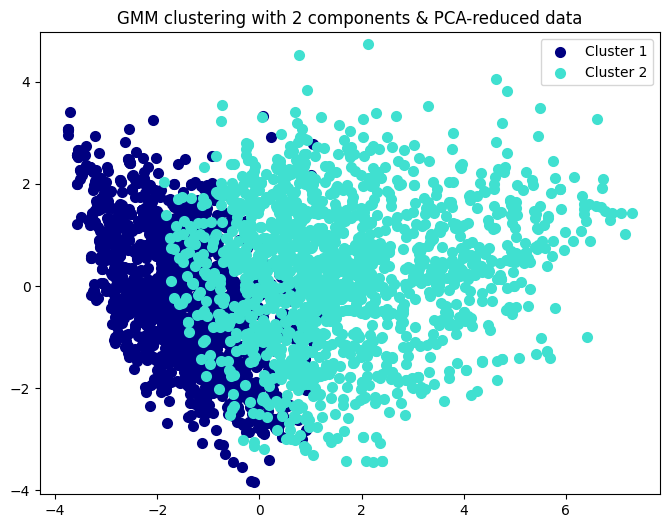

In [27]:
# Apply PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
X_pca = pca.fit_transform(X_scaled)

# Plot the clustered data
plt.figure(figsize=(8, 6))
colors = ['navy', 'turquoise']
cluster_names = ['Cluster 1', 'Cluster 2']

for color, i, cluster_name in zip(colors, range(3), cluster_names):
    plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], color=color, lw=2, label=cluster_name)

plt.title('GMM clustering with 2 components & PCA-reduced data')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.axis('equal')
plt.show()

### Catboost with cluster

In [28]:
# Setting up the Gaussian Mixture Model for clustering
gmm1 = GaussianMixture(n_components=4, random_state=42)
gmm1.fit(X)
clusters1 = gmm1.predict(X)

# Add the cluster assignments as a new feature without losing the DataFrame format
X_with_clusters_1 = X.copy()  # Copy the DataFrame
X_with_clusters_1['Cluster'] = clusters1  # Add a new column for clusters

# Split the data into training and testing sets
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_with_clusters_1, y, test_size=0.3, random_state=42)

# Initialize and train the CatBoostClassifier
# Assuming 'Age' is the only categorical feature
categorical_features = ['Age']

# Initialize and train the CatBoostClassifier with categorical features specified
catboost_model_cluster = CatBoostClassifier(
    # iterations=100,
    # learning_rate=0.1,
    # depth=5,
    cat_features=categorical_features,  # Specify categorical features here
    verbose=False
)

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'depth': [4, 5, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Set up GridSearchCV
grid_cluster = GridSearchCV(estimator=catboost_model_cluster, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_cluster.fit(X_train_cluster, y_train_cluster)

# catboost_model1.fit(X_train1, y_train1)

# Make predictions and evaluate the model
best_model_cluster = grid_cluster.best_estimator_
predictions_cluster = best_model_cluster.predict(X_test_cluster)
# predictions_cluster = grid_cluster.predict(X_test1)

In [29]:
# Evaluate the model
accuracy_cluster = accuracy_score(y_test_cluster, predictions_cluster)
print(f"Accuracy: {accuracy_cluster}")

Accuracy: 0.9211356466876972


#### Fairness through unawareness (exclude all protected attributes)
#### conclude: more accurate and more fair

In [30]:
# Drop multiple columns: 'Age' and 'City'
df_drop_protected_features = df.drop(['Age', 'Gender'], axis=1)

In [31]:
df_drop_protected_features

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,2,2,5,13,2,10,3,4,55,3,...,4,10,2,2,10,7,0,8,0,3
1,2,2,5,13,2,14,4,4,42,3,...,4,20,2,3,7,7,1,7,0,3
2,1,1,5,13,1,5,4,4,48,2,...,3,20,2,3,18,13,1,12,0,4
3,0,0,3,8,2,10,4,2,73,2,...,2,23,2,2,21,6,12,6,0,3
4,2,2,5,13,2,16,4,1,84,3,...,4,10,1,3,2,2,2,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,1,0,3,9,1,20,3,3,80,1,...,3,9,2,1,4,3,1,2,0,3
3166,1,2,2,13,1,2,1,2,79,3,...,2,9,1,2,7,6,2,5,0,2
3167,1,2,1,3,2,2,2,1,47,2,...,3,1,3,2,1,0,0,0,1,3
3168,1,1,4,11,1,2,3,1,52,2,...,2,14,4,3,4,2,2,2,0,2


In [32]:
X_drop_protected_f = df_drop_protected_features.iloc[:,1:-1]
y = df_drop_protected_features.iloc[:,-1]

In [33]:
X_drop_protected_f

,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,...,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,2,5,13,2,10,3,4,55,3,2,...,12,4,10,2,2,10,7,0,8,0
1,2,5,13,2,14,4,4,42,3,2,...,12,4,20,2,3,7,7,1,7,0
2,1,5,13,1,5,4,4,48,2,3,...,21,3,20,2,3,18,13,1,12,0
3,0,3,8,2,10,4,2,73,2,5,...,15,2,23,2,2,21,6,12,6,0
4,2,5,13,2,16,4,1,84,3,2,...,14,4,10,1,3,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,0,3,9,1,20,3,3,80,1,2,...,13,3,9,2,1,4,3,1,2,0
3166,2,2,13,1,2,1,2,79,3,1,...,14,2,9,1,2,7,6,2,5,0
3167,2,1,3,2,2,2,1,47,2,1,...,18,3,1,3,2,1,0,0,0,1
3168,1,4,11,1,2,3,1,52,2,3,...,11,2,14,4,3,4,2,2,2,0


In [34]:
y

0       3
1       3
2       4
3       3
4       3
       ..
3165    3
3166    2
3167    3
3168    2
3169    3
Name: PerformanceRating, Length: 3170, dtype: int64

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_drop_protected_f)

# Fit GMM with three components
gmm = GaussianMixture(n_components=2, random_state=0)  # Use three clusters
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)  # Get cluster labels for each data point

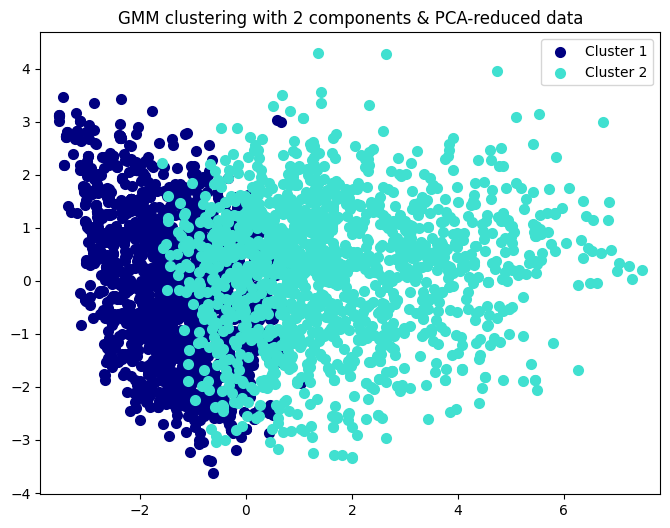

In [36]:
# Apply PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
X_pca = pca.fit_transform(X_scaled)

# Plot the clustered data
plt.figure(figsize=(8, 6))
colors = ['navy', 'turquoise']
cluster_names = ['Cluster 1', 'Cluster 2']

for color, i, cluster_name in zip(colors, range(3), cluster_names):
    plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], color=color, lw=2, label=cluster_name)

plt.title('GMM clustering with 2 components & PCA-reduced data')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.axis('equal')
plt.show()

In [37]:
# Setting up the Gaussian Mixture Model for clustering
gmm1 = GaussianMixture(n_components=4, random_state=42)
gmm1.fit(X_drop_protected_f)
clusters1 = gmm1.predict(X_drop_protected_f)

# Add the cluster assignments as a new feature without losing the DataFrame format
X_with_clusters_1 = X_drop_protected_f.copy()  # Copy the DataFrame
X_with_clusters_1['Cluster'] = clusters1  # Add a new column for clusters

# Split the data into training and testing sets
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_with_clusters_1, y, test_size=0.3, random_state=42)

# Initialize and train the CatBoostClassifier
# catboost_model1 = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=15, verbose=False)


# Initialize and train the CatBoostClassifier with categorical features specified
catboost_model_cluster = CatBoostClassifier(
    # iterations=100,
    # learning_rate=0.1,
    # depth=5,
      # Specify categorical features here
    verbose=False
)

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'depth': [4, 5, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Set up GridSearchCV
grid_cluster = GridSearchCV(estimator=catboost_model_cluster, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_cluster.fit(X_train_cluster, y_train_cluster)

# catboost_model1.fit(X_train1, y_train1)

# Make predictions and evaluate the model
best_model_cluster = grid_cluster.best_estimator_
predictions_cluster = best_model_cluster.predict(X_test_cluster)
# predictions_cluster = grid_cluster.predict(X_test1)

In [38]:
# Evaluate the model
accuracy_cluster = accuracy_score(y_test_cluster, predictions_cluster)
# print(f"Accuracy: {accuracy_cluster}")
print(f'Accuracy: {accuracy_cluster:.3f}')
print(classification_report(y_test_cluster,predictions_cluster))

Accuracy: 0.913
              precision    recall  f1-score   support

           2       0.90      0.85      0.87       253
           3       0.92      0.96      0.94       648
           4       0.92      0.68      0.78        50

    accuracy                           0.91       951
   macro avg       0.91      0.83      0.86       951
weighted avg       0.91      0.91      0.91       951



In [39]:
# Now, you can access feature_importances_ from this model
feature_importances = best_model_cluster.feature_importances_

# If X_train is indeed a DataFrame, you can get the feature names directly:
feature_names =  X_drop_protected_f.columns

# Store feature importances and names in a list and sort them by importance
importance_name_pairs = sorted(zip(feature_importances, feature_names), reverse=True)

# Display the top 5 most important features
print("Top 5 Most Important Features:")
for name, importance in importance_name_pairs[:5]:
    print(name,importance)


Top 5 Most Important Features:
16.49390607607623 EmpEnvironmentSatisfaction
11.544343292663903 EmpLastSalaryHikePercent
8.080934702567124 YearsSinceLastPromotion
6.76667481762867 EmpHourlyRate
4.8146065420672555 EmpJobRole
